<a href="https://colab.research.google.com/github/LennyRBriones/neural-networks-practices/blob/main/Brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [1]:
import os
import zipfile

local_zip ="/content/drive/MyDrive/brain_class.zip"
zip_ref = zipfile.ZipFile(local_zip,"r")
zip_ref.extractall("content/drive/MyDrive/brain_class")
zip_ref.close()

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
train_dir = "content/drive/MyDrive/brain_class/Training"
test_dir = "content/drive/MyDrive/brain_class/Testing"

## Data Generators

In [8]:
train_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255, validation_split = 0.2) # splitting in 20% to validate performance

In [10]:
from tensorflow.python import test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (512, 512),
    batch_size = 12,
    class_mode = "categorical",
    color_mode = "grayscale",
    subset ="training"
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (512, 512),
    batch_size = 12,
    class_mode = "categorical",
    color_mode = "grayscale",
    subset = "validation"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (512, 512),
    batch_size = 12,
    class_mode = "categorical",
    color_mode = "grayscale",
)

Found 5712 images belonging to 4 classes.
Found 262 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [11]:
classes = ["glioma", "meningioma", "notumor", "pituitary"]

In [12]:
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [16]:
def plotimages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize = (15,15))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img[:,:,0])
    ax.axis("off")
  plt.tight_layout()
  plt.show()

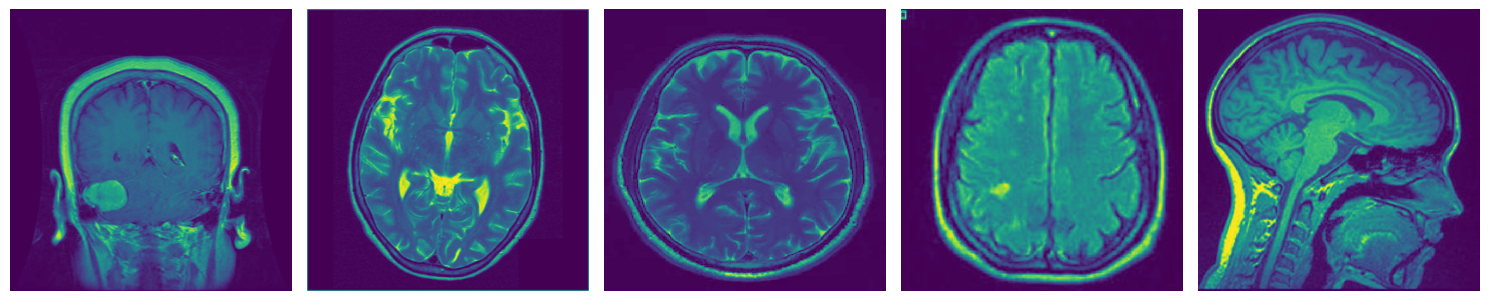

In [17]:
sample_training_images, _ = next(train_generator)
plotimages(sample_training_images[5:10])

## Keras Tuner

In [19]:
from tensorflow.keras import regularizers

In [18]:
! pip install -q -U keras-tuner
import keras_tuner as kt
from tensorflow import keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.6 MB/s eta 0:00:00


In [20]:
def model_constructor(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(20, (3,3), activation ="relu", input_shape = (512,512, 1)))
  model.add(tf.keras.layers.MaxPool2D((2,2)))
  model.add(tf.keras.layers.Flatten())

  #Dynamic generator of neurons
  hp_units = hp.Int("units", min_value = 4, max_value = 52, step = 4)
  model.add(tf.keras.layers.Dense(units = hp_units, activation = "relu", kernel_regularizer = regularizers.l2(1e-5)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(28, activation = "relu", kernel_regularizer= regularizers.l2(1e-5)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(len(classes), activation = "softmax" ))

  hp_learning_rate = hp.Choice("learning_rate", values = [1e-2, 1e-3, 1e-4])

  model.compile(optimizer = keras.optimizers.Adam(learning_rate= hp_learning_rate), loss = "categorical_crossentropy", metrics = ["accuracy"])

  return model

In [22]:
tuner = kt.Hyperband(
    model_constructor,
    objective = "val_accuracy", #to see generalization in new data
    max_epochs=20,
    factor = 3,
    directory = "models/",
    project_name = "brain-tunner"
)

In [ ]:
tuner.search(train_generator, epochs = 20, validation_data = validation_generator)

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
                                          #trials help us to re-test the result

Trial 5 Complete [01h 10m 09s]
val_accuracy: 0.7519084215164185

Best val_accuracy So Far: 0.8778625726699829
Total elapsed time: 05h 31m 05s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
24                |52                |units
0.0001            |0.001             |learning_rate
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3
476/476 [==============================] - 1162s 2s/step - loss: 1.2471 - accuracy: 0.4095 - val_loss: 1.2081 - val_accuracy: 0.5038
Epoch 2/3
304/476 [==================>...........] - ETA: 6:54 - loss: 1.1408 - accuracy: 0.4608

In [ ]:
print(best_hps.get("units")) #to get the best configuration of neurons

In [ ]:
print(best_hps.get("learning_rate")) #to get the best configuration of learning rate